In [1]:
from bayesian_linear_regression import *
from matplotlib import pyplot as plt

## THE AIM OF THIS FILE IS TO CROSS CHECK IF THE RATIO ESTIMATOR IS WORKING WELL AND PICK OUT ANY INTERESTING PROPERTIES

In [30]:
N = 500
beta_true=5
X, Y = linear_dataset(beta_true=beta_true, N=N, noise_std=0.1)

train_dataset = TensorDataset(torch.from_numpy(
    X).float(), torch.from_numpy(Y).float())

BATCH_SIZE = 500
data_loader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE)

The ratio estimator (or more accurately the log ratio estimator) $r(\beta, y_i; \theta)$ is meant to approximate

$$r(\beta, y_i; \theta) \approx \log\frac{p(y_i | \beta, x_i)}{q(y_i | x_i)}$$

where $q(y_i)$ is the empirical distribution and $\theta$ is the parameter of the estimator (i.e. the weights of the network).

Since $q(y_i | x_i)$ is a constant, we would expect that when $r$ is at its optimium i.e. $ r^*(\beta, y_i) = \log\frac{p(y_i | \beta, x_i)}{q(y_i | x_i)} $ that 

$$\log p(x_i | \beta, x_i) - r^*(y_i, \beta) = const $$

The code below and plot tries to estimate log_q/the const above by traning the ratio estimator with beta from two different distribution. 

One distribution has a mean far from the true and the other has a close/exactly at the true beta.

In [31]:
def estimate_log_qs(beta_distn, epochs=1000, print_losses=False, print_interval=100):
  """
  If print_inverval is -1 it would only print the first and last loss
  """
  if print_interval == -1:
        print_interval = epochs
        
  ratio_estimator = RatioEstimator(in_features=2)
  ratio_optimizer = optim.Adam(ratio_estimator.parameters(), lr=0.1)
  ratio_lr_sch = torch.optim.lr_scheduler.ExponentialLR(
      ratio_optimizer, (0.9)**(1/100))

  noise_std = 1
  model_simulator = NormalLikelihoodSimulator(noise_std)

  # To see stability of ratio estimator
  log_qs = []

  for epoch in range(epochs):
      ratio_lr_sch.step()

      for batch in data_loader_train:
          beta_sample = beta_distn.sample()
          ratio_loss = train_ratio_estimator(
              beta_sample, ratio_estimator, model_simulator, None, batch, ratio_optimizer)

          ratio_loss.backward()
          ratio_optimizer.step()
      
      if print_losses:
        if epoch == 0 or (epoch+1) % print_interval == 0:
          print("Epoch:{0}, ratio_loss:{1}".format(epoch, ratio_loss.detach().item()))
      
      ratio_estimator.eval()
      with torch.no_grad():
          beta_sample = beta_distn.sample().double().item()

          estimate_log_q = model_simulator.log_prob(Y
          [0], beta_sample, X[0]) - ratio_estimator(torch.tensor([beta_sample, Y[0]], dtype=torch.float).unsqueeze(0)).item()

          log_qs.append(estimate_log_q)
  return log_qs

Epoch:0, ratio_loss:1.4134232997894287
Epoch:499, ratio_loss:1.1105138063430786


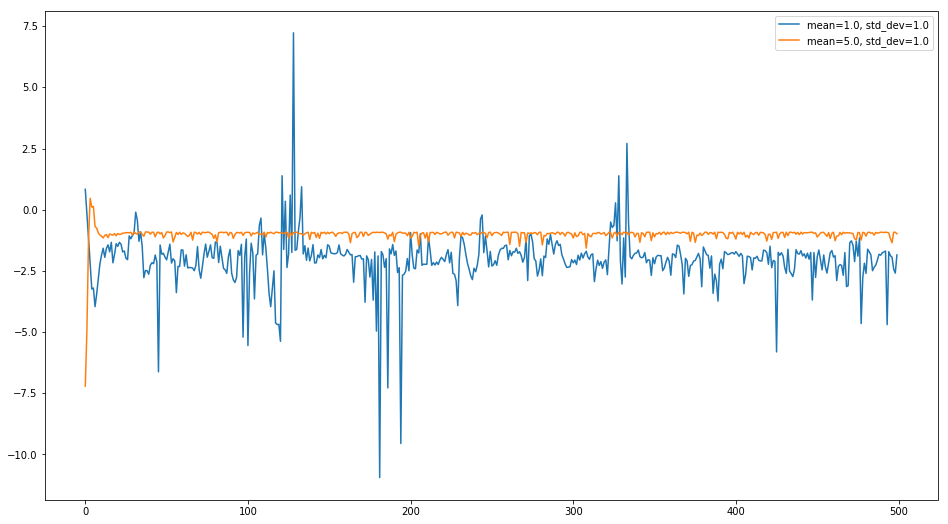

In [32]:
beta_distn_1 = trd.Normal(1, 1)
beta_distn_2 = trd.Normal(beta_true, 1)

plt.figure(figsize=(16, 9))
plt.plot(estimate_log_qs(beta_distn_1, epochs=500, print_losses=True, print_interval=-1), 
         label="mean={}, std_dev={}".format(beta_distn_1.mean, beta_distn_1.stddev))

plt.plot(estimate_log_qs(beta_distn_2, epochs=500, print_losses=True, print_interval=-1),
        label="mean={}, std_dev={}".format(beta_distn_2.mean, beta_distn_2.stddev))

plt.legend()
plt.show()

We can see that the when beta is sampled from a distribution with mean equal to the true beta the ratio estimator appears to converge after a few iterations unlike when the mean is far from the true beta. In the later case the ratio estimator doesn't appear to be converging. This is exactly the same result demostrated in the appendix of the paper [Hierarchical Implicit Models and Likelihood-Free Variational Inference](https://arxiv.org/abs/1702.08896) (figure 6)

Training for longer using the betas in range \[0, beta_true).

Epoch:0, ratio_loss:1.5515655279159546
Epoch:4999, ratio_loss:1.0504823923110962
Epoch:0, ratio_loss:1.361073613166809
Epoch:4999, ratio_loss:1.1420059204101562
Epoch:0, ratio_loss:1.586097002029419
Epoch:4999, ratio_loss:1.1882268190383911
Epoch:0, ratio_loss:1.7020072937011719
Epoch:4999, ratio_loss:1.348534345626831
Epoch:0, ratio_loss:1.51017165184021
Epoch:4999, ratio_loss:1.314303994178772


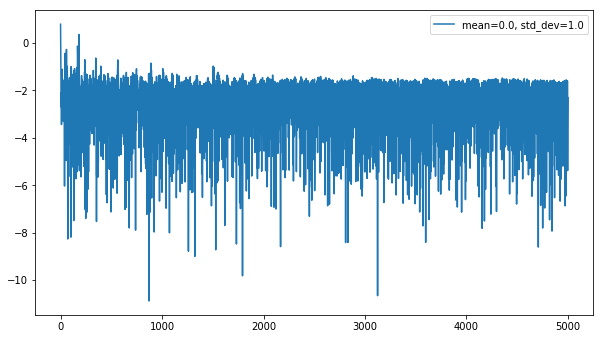

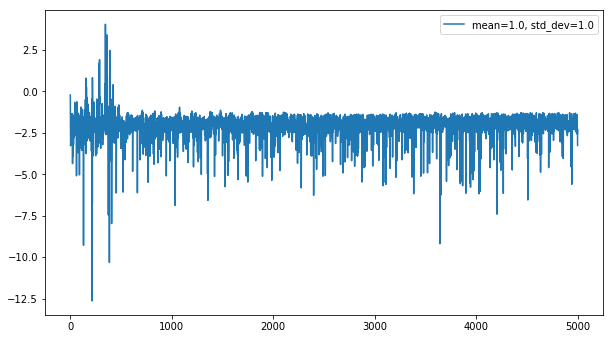

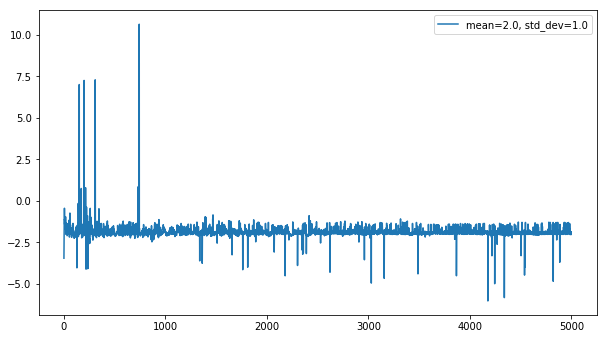

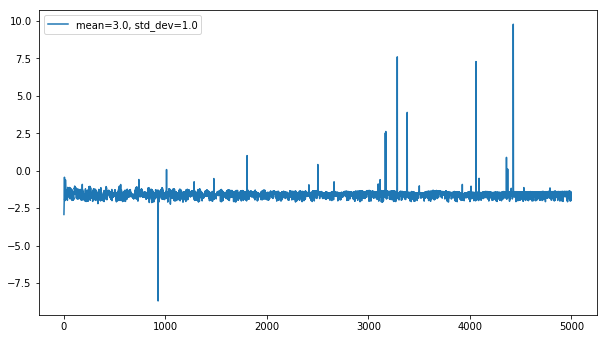

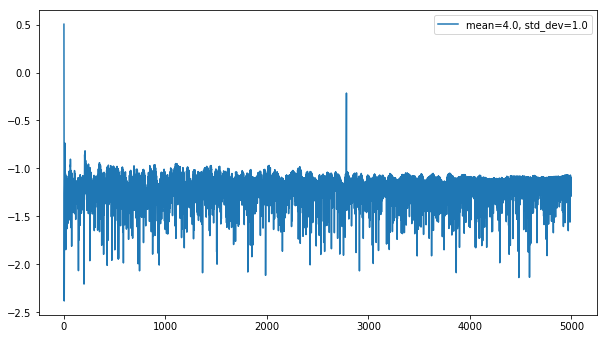

In [37]:
for mean in range(beta_true):
  beta_distn_1 = trd.Normal(mean, 1)

  plt.figure(figsize=(10, 5.6))

  plt.plot(estimate_log_qs(beta_distn_1, epochs=5000, print_losses=True, print_interval=-1),
        label="mean={}, std_dev={}".format(beta_distn_1.mean, beta_distn_1.stddev))
  
  plt.legend()

plt.show()